In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)

cur = db.cursor()

# List all unique cities where customers are located.

In [2]:
query ="""select distinct customer_city from customers """

cur.execute(query)

data =cur.fetchall()

df = pd.DataFrame(data)
df.head() 

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [3]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data =cur.fetchall()

"total order placed in 2017 are", data[0][0]

('total order placed in 2017 are', 45101)

# Find the total sales per category.

In [4]:
query = """
select products.product_category as category,
       round(sum(payments.payment_value),2) as sales 
from products 
join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns =["category","sales"])
df


,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.

In [5]:
query = """
select (sum(case when payment_installments >=1 then 1
else 0 end))*100/count(*) from payments
"""

cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments", data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

# Count the number of customers from each state. 

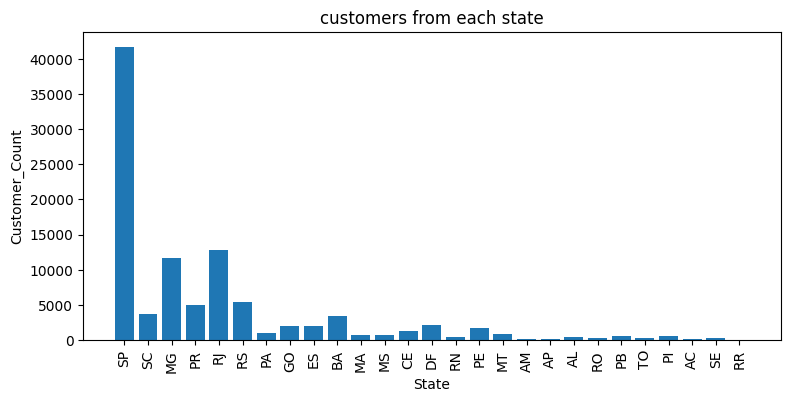

In [6]:
query ="""select customer_state, count(customer_id) from customers group by customer_state """

cur.execute(query)

data =cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
df
plt.figure(figsize =(9,4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("State")
plt.ylabel("Customer_Count")
plt.title("customers from each state")
plt.show()

# Calculate the number of orders per month in 2018.

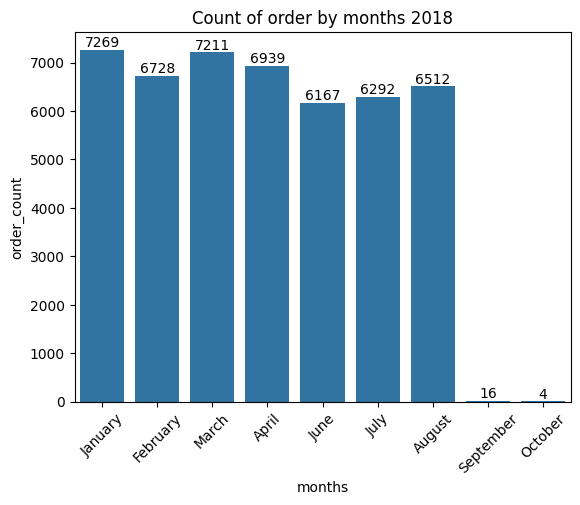

In [7]:
query ="""select monthname(order_purchase_timestamp) as months, count(order_id) as order_count from orders where year(order_purchase_timestamp) = 2018 group by months """

cur.execute(query)

data =cur.fetchall()

df =pd.DataFrame(data, columns =["months", "order_count"])
o =["January","February","March","April","June","July","August","September","October"]
ax = sns.barplot(x="months", y="order_count", data=df, order=o)
plt.xticks(rotation =45)
ax.bar_label(ax.containers[0])
plt.title("Count of order by months 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [8]:
query = """
select
    customers.customer_city as city,
    round(avg(order_product_count.product_count),2) as avg_products_per_order
from customers
join orders  on customers.customer_id = orders.customer_id
join (
    select 
        order_id, 
        count(order_item_id) as product_count
    from order_items
    group by order_id
) as order_product_count ON orders.order_id = order_product_count.order_id
group by customers.customer_city
order by avg_products_per_order desc;
"""
cur.execute(query)

data =cur.fetchall()
df = pd.DataFrame(data, columns =["customer city", "average product/order"])
df.head(10)

,customer city,average product/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,curralinho,4.00
8,teixeira soares,4.00
9,morro de sao paulo,4.00


# Calculate the percentage of total revenue contributed by each product category.


In [9]:
query = """
select products.product_category as category,
       round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales_percentage
from products 
join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns =["category","sales percentage"])
df.head(10)


,category,sales percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query ="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by  products.product_category;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns =["category","order_count","price"])

arr1 =df["order_count"]
arr2 =df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue

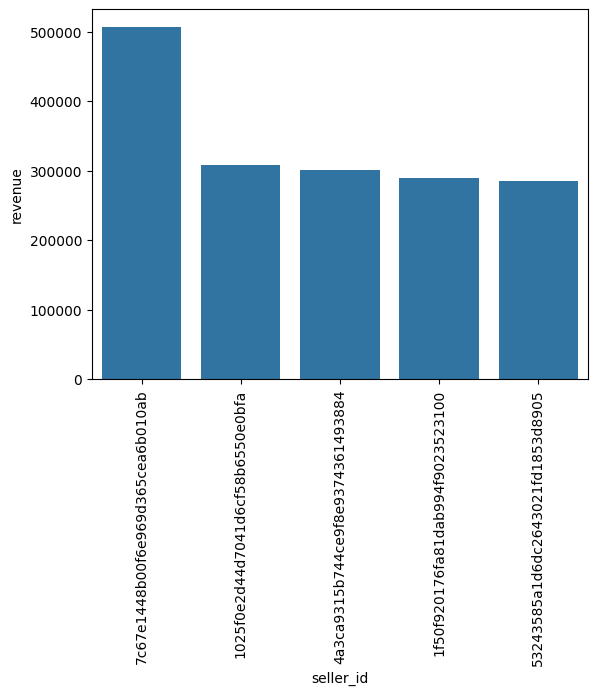

In [11]:
query ="""select *,dense_rank() over (order by revenue desc) as rn from
(select order_items.seller_id,
sum(payments.payment_value) as revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x ="seller_id", y="revenue", data =df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [12]:
query = """
select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a;
"""


cur.execute(query)

# Fetch all results
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [13]:
query ="""select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
sum(payments.payment_value) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a;"""

cur.execute(query)

# Fetch all results
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,2.522400e+02,2.522400e+02
1,2016,10,5.909048e+04,5.934272e+04
2,2016,12,1.962000e+01,5.936234e+04
3,2017,1,1.384880e+05,1.978504e+05
4,2017,2,2.919080e+05,4.897584e+05
5,2017,3,4.498636e+05,9.396220e+05
6,2017,4,4.177880e+05,1.357410e+06
7,2017,5,5.929188e+05,1.950329e+06
8,2017,6,5.112764e+05,2.461605e+06
9,2017,7,5.923829e+05,3.053988e+06


# Calculate the year-over-year growth rate of total sales.

In [15]:
query = """
with yearly_sales as (
    select 
        year(o.order_purchase_timestamp) AS years,
        sum(p.payment_value) as total_sales
    from payments p
    join orders o ON p.order_id = o.order_id
    group by years
),
yoy_growth as (
    select 
        years,total_sales, lag(total_sales) over (order by years) as previous_year_sales,
        round((total_sales - lag(total_sales) over (order by years)) / 
            lag(total_sales) over (order by years) * 100, 2) as yoy_growth_rate
    from yearly_sales
)
select * from yoy_growth;
"""

# Execute query
cur.execute(query)

# Fetch data and convert to DataFrame
data = cur.fetchall()
columns = ["year", "total_sales", "previous_year_sales", "yoy_growth_rate"]
df = pd.DataFrame(data, columns=columns)
df

,year,total_sales,previous_year_sales,yoy_growth_rate
0,2016,5.936234e+04,NaN,NaN
1,2017,7.249747e+06,5.936234e+04,12112.7
2,2018,8.699763e+06,7.249747e+06,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [17]:
query = """
WITH first_purchase AS (
    SELECT 
        customer_id,
        MIN(order_purchase_timestamp) AS first_purchase_date
    FROM orders
    GROUP BY customer_id
),
repeat_purchase AS (
    SELECT 
        o.customer_id,
        COUNT(o.order_id) AS repeat_count
    FROM orders o
    JOIN first_purchase fp 
        ON o.customer_id = fp.customer_id
        AND o.order_purchase_timestamp > fp.first_purchase_date
        AND o.order_purchase_timestamp <= DATE_ADD(fp.first_purchase_date, INTERVAL 6 MONTH)
    GROUP BY o.customer_id
),
retention_rate AS (
    SELECT 
        fp.customer_id,
        CASE 
            WHEN rp.repeat_count > 0 THEN 1
            ELSE 0
        END AS is_retained
    FROM first_purchase fp
    LEFT JOIN repeat_purchase rp 
        ON fp.customer_id = rp.customer_id
)
SELECT 
    ROUND(SUM(is_retained) / COUNT(*) * 100, 2) AS retention_rate
FROM retention_rate;
"""

cur.execute(query)

# Fetch all results
data = cur.fetchall()
data

[(Decimal('0.00'),)]

# Identify the top 3 customers who spent the most money in each year.

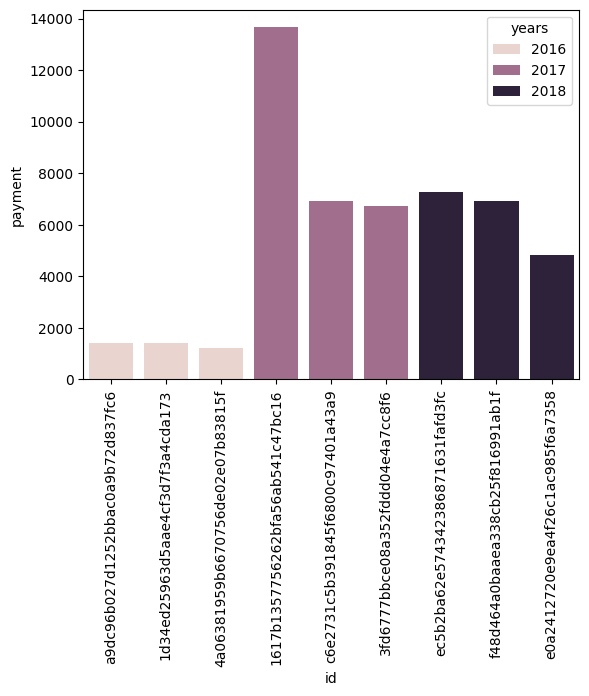

In [19]:
query =""" select years, customer_id, payment, d_rank from
(select year(orders.order_purchase_timestamp) as years, 
orders.customer_id, 
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) as d_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank<=3; """

cur.execute(query)

# Fetch all results
data = cur.fetchall()
df = pd.DataFrame(data, columns =["years", "id","payment","rank"])
sns.barplot(x ="id", y ="payment", data =df, hue ="years")
plt.xticks( rotation =90)
plt.show()